# Fabrication additive

In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import dolfin as df
%matplotlib inline
plt.rcParams['figure.figsize']=(20, 15)
#df.parameters["plotting_backend"] = "vtk"

### Données géométriques (SI)

In [2]:
# SLM 500 (longueur, largeur, épaisseur d'une couche)
L = 0.5 # [m]
l = 0.28 # [m]
e = 100.e-6 # [m]
# Puissance du laser
P = 400. # [W]
# Vitesse de balayage du laser
v_laser = 1.6 # vitesse du laser [m/s]
d_laser = 0.001  # diametre du laser [m]

### Données matériau (SI)

In [3]:
# Caractéristiques de Ta6V
E = 112.E9 # module d'Young [Pa]
nu = 0.34 # coefficient de Poisson
mu = df.Constant(E/(2.*(1.+nu))) # coeffient de Lamé [Pa]
lmbda = df.Constant(E*nu/((1.+nu)*(1.-2.*nu))) # coeffient de Lamé [Pa]
K = 6.2 # conductivité thermique [W/m/K]
Cp = 2.3e6 # capacité calorifique volumique [J/m3/K]
#Cp = Cpv*L*l*e # capacité calorifique [J/K]
alpha = 8.E-6 # coefficient de dilatation [1/K]

### Maillage

In [4]:
x1min, x1max = 0, L
x2min, x2max = 0, l
x3min, x3max = 0, e

### Création d'un fichier paraview

In [5]:
file_mesh = df.File("output_f3/FA.pvd")

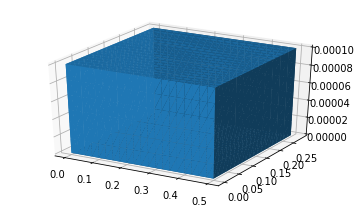

In [6]:
#T1 = df.Constant(100.)
#T0 = df.Constant(0.)

p0 = df.Point(x1min, x2min, x3min);
p1 = df.Point(x1max, x2max, x3max);
mesh = df.BoxMesh(p0, p1, 20, 20, 6)
file_mesh << (mesh)
df.plot(mesh)

ndim = mesh.geometric_dimension()

In [7]:
def boundary(x, on_boundary):
    return on_boundary

### Initialisation temporelle

In [8]:
num_steps = 100     # number of time steps

#T = x2max/(dt*v_laser)*(x1max/v_laser)         # final time
T = df.sqrt(num_steps*x2max*x1max)/v_laser
dt = T / num_steps # time step size

### Initialisation thermique

In [9]:
V = df.FunctionSpace(mesh, 'P', 1)

# Condition initiale
u_D = df.Constant('293.')
bc = df.DirichletBC(V, u_D, boundary)

# Define initial value
u_n = df.interpolate(u_D, V)

In [17]:
class Up(df.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return df.near(x[2], x3max, tol) and on_boundary
    
Up = Up()    
boundaries = df.FacetFunction("size_t", mesh)
boundaries.set_all(0)
Up.mark(boundaries, 1)
ds = Measure("ds")[boundaries]

x11 = 0.
x22 = 0.

# Define variational problem
u_ = df.TrialFunction(V)    
v = df.TestFunction(V)
u = df.Function(V)

#f = df.Expression('x[2]>x3max-eps/100.?P/(d_laser*sqrt(2.*pi))*exp(- (pow((x[0]- x11), 2) + pow((x[1] - x22), 2))/(2.*d_laser)):0.', P=P, x11=x11, x22=x22, d_laser=d_laser, x3max=x3max,eps=df.DOLFIN_EPS,degree=2)
f = df.Expression('P/(d_laser*sqrt(2.*pi))*exp(- (pow((x[0]- x11), 2) + pow((x[1] - x22), 2))/(2.*d_laser))', P=P, x11=x11, x22=x22, d_laser=d_laser, x3max=x3max,eps=df.DOLFIN_EPS,degree=2)

a = Cp*u_*v*df.dx + K*dt*df.dot(df.grad(u_), df.grad(v))*df.dx
L = (Cp*u_n*v*df.dx + dt*f*v*ds(1))


AttributeError: module 'dolfin' has no attribute 'facetFunction'

### Initialisation mécanique

### Boucle temporelle

Calling FFC just-in-time (JIT) compiler, this may take some time.


/opt/fenics-2018.1/lib/python3.5/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


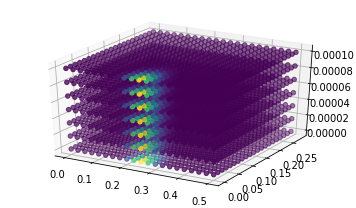

In [11]:
x_n = (x1max-x1min)/2.
y_n = (x2min)
f.x11 = x_n
f.x22 = y_n
graph=df.Function(V)
graph.assign(df.project(f,V))
plt.figure(0)
df.plot(graph)
    
for n in range(num_steps):

    #update source position
    f.x11 = x_n
    f.x22 = y_n
    
    df.solve(a == L, u, bc)

    # Plot solution
    #df.plot(u)

    # Update previous solution
    u_n.assign(u)
    graph.assign(df.project(f,V))
    #plt.figure(n)
    #df.plot(graph)
    #uu=df.plot(u)
    #plt.colorbar(uu)
    
    #save  solution  in  ParaView  format
    file_mesh << (u,n)
    
    #print(x_n)
    #print(y_n)
    #print(df.norm(u))
    #print(' ')
    
    # Position du laser
    
    if (x_n + dt*v_laser) >= x1max - (dt*v_laser/2.):
        x_n = dt*v_laser/2. 
        y_n += dt*v_laser
    else:
        x_n += dt*v_laser
        
    if (y_n + dt*v_laser) >= x2max - (dt*v_laser/2.):
        break

        
#Hold plot
#df.interactive()
